In [1]:
%pwd

'/Users/dima/wrk/rwth10-hodge-helmholtz-pinn/tasks/03-2021-09-16-preprocessing'

# 03-2021-09-16-preprocessing

## Setup

In [1]:
# %load code/experiments/03-2021-09-16-preprocessing.py
#!/usr/bin/env python
%matplotlib inline
import argparse
import os

import matplotlib.pyplot as plt
import numpy as np

import hhpinn

from typing import Dict, List

from hhpinn import HodgeHelmholtzPINN
from hhpinn.utils import render_figure


OUTDIR = "_output"

CONFIGS = [
    [10],
    [20],
    [50],
    [100],
    [1000],
]

RESULT_MODEL_TEMPLATE = os.path.join(OUTDIR, "model-{:d}")

## Compute

In [2]:
ds = hhpinn.datasets.TGV2D()
train_x, train_u = ds.load_data()

In [3]:
models: List[HodgeHelmholtzPINN] = []
for i, c in enumerate(CONFIGS):
    model = HodgeHelmholtzPINN(
        hidden_layers=c,
        epochs=1000,
        learning_rate=0.01,
    )
    models.append(model)
    model.fit(train_x, train_u)
    savedir = RESULT_MODEL_TEMPLATE.format(i)
    os.makedirs(savedir)
    model.save(savedir)

2021-09-17 17:30:48.683264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: _output/model-0/model/assets


2021-09-17 17:30:51.369624: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: _output/model-1/model/assets
INFO:tensorflow:Assets written to: _output/model-2/model/assets
INFO:tensorflow:Assets written to: _output/model-3/model/assets
INFO:tensorflow:Assets written to: _output/model-4/model/assets


## Results

In [3]:
args = {"save": True}

Load the results from disc:

In [5]:
ds = hhpinn.datasets.TGV2D()
train_x, train_u = ds.load_data()

models: List[HodgeHelmholtzPINN] = []
for i, c in enumerate(CONFIGS):
    m = HodgeHelmholtzPINN.load(
        RESULT_MODEL_TEMPLATE.format(i)
    )
    models.append(m)

2021-09-22 16:00:30.346660: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


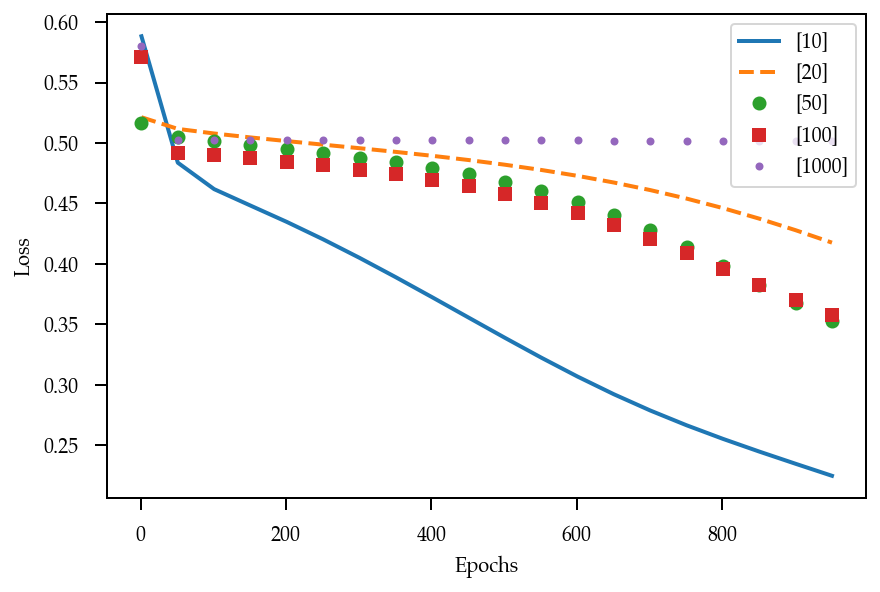

In [6]:
styles = ["-", "--", "o", "s", "."]
plt.figure()
for i, c in enumerate(CONFIGS):
    plt.plot(
        range(1, len(models[i].history["loss"])+1, 50),
        models[i].history["loss"][::50],
        styles[i],
        label=c)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.tight_layout(pad=0.3)

render_figure(
    to_file=os.path.join("_assets", "loss-history.pdf"),
    save=args["save"]
)

Now let's plot true and predicted field. Also the pointwise error field.

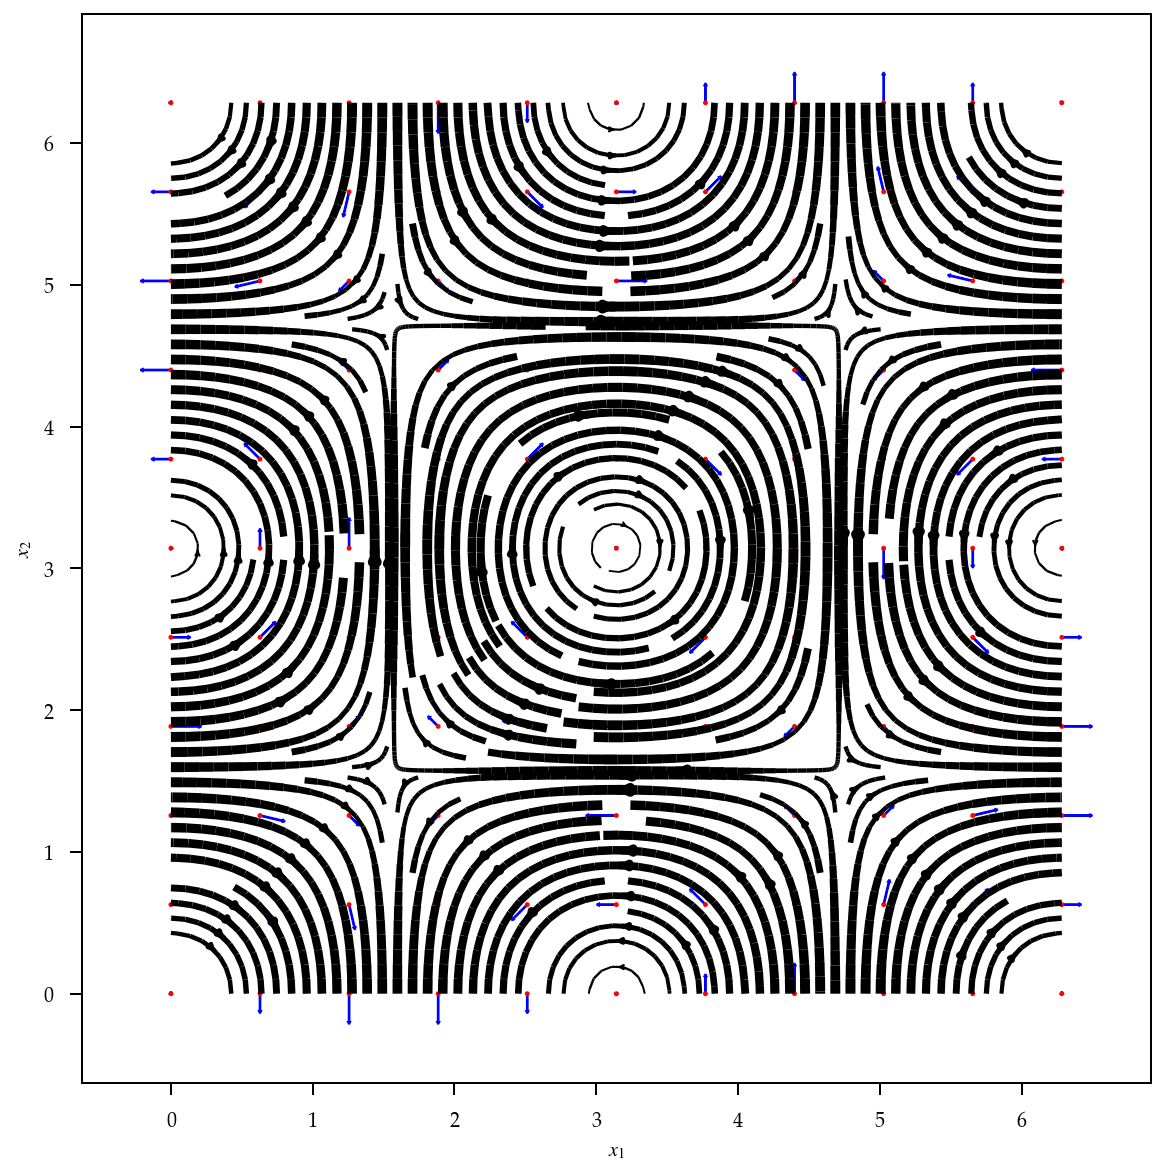

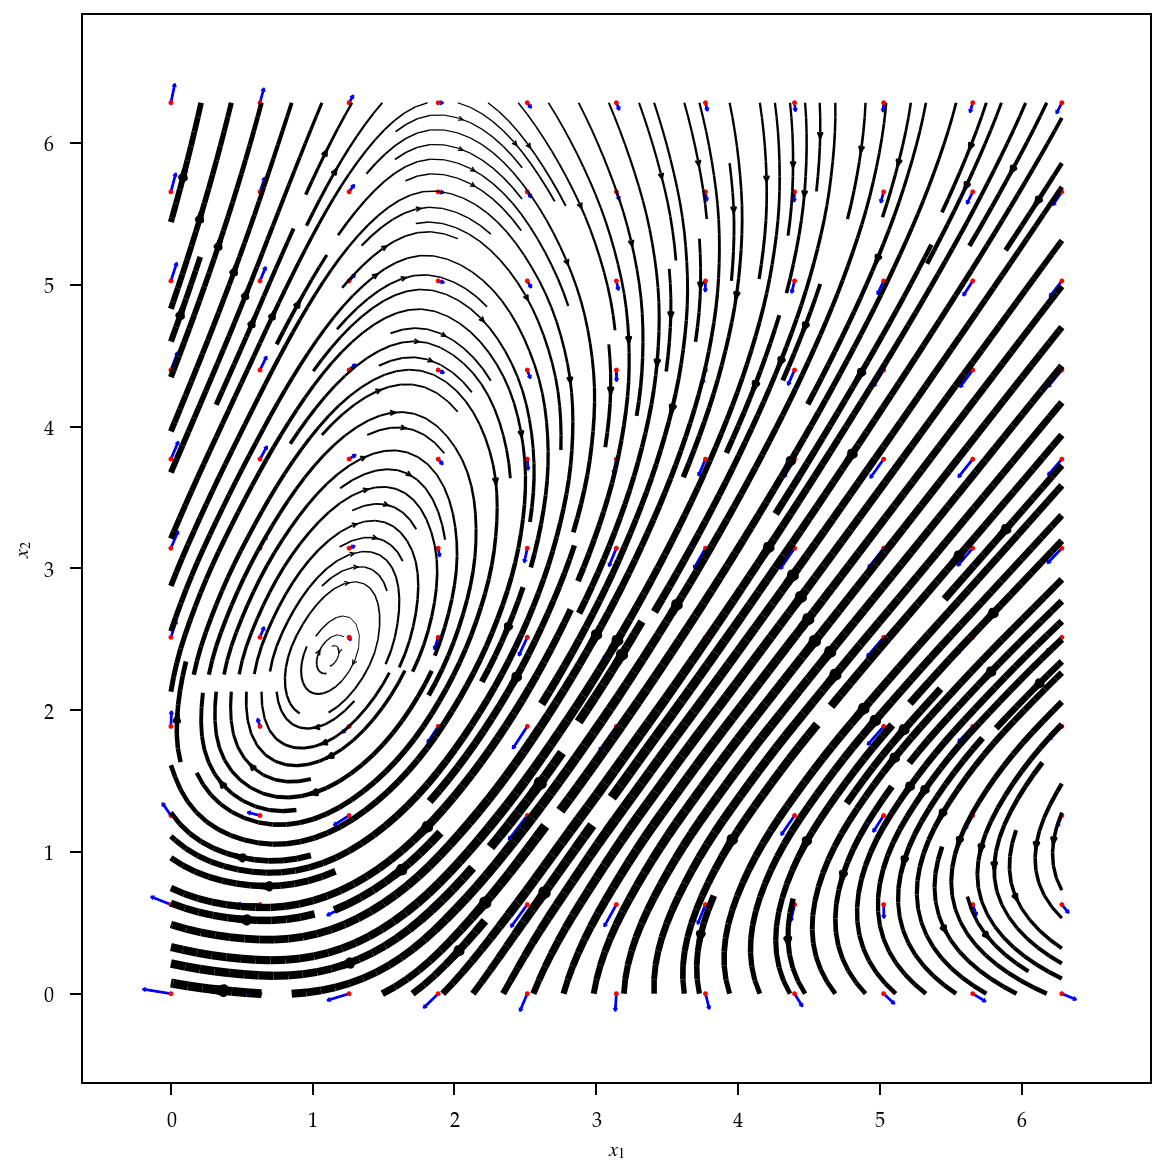

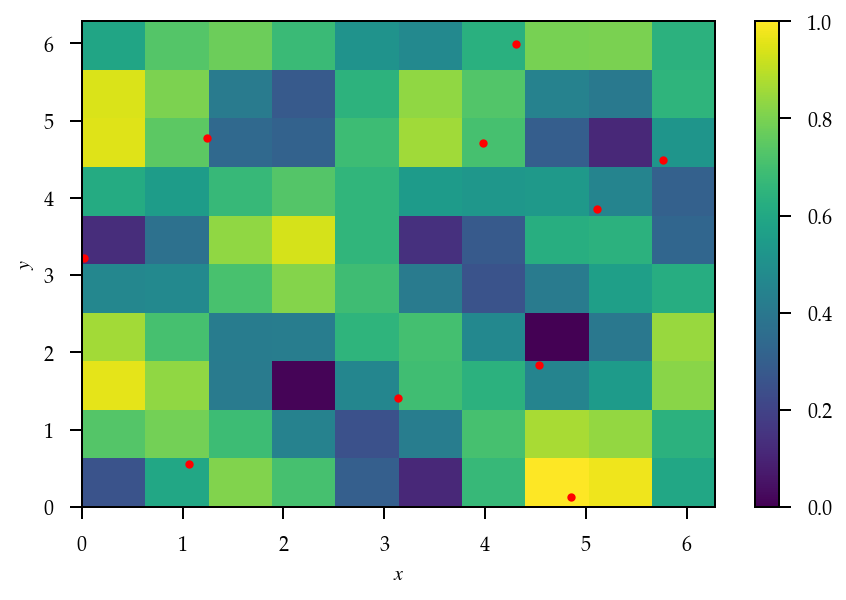

In [7]:
model = models[1]

grid_size = (11, 11)
test_x, test_u = ds.load_data_on_grid(grid_size)
pred_u = model.predict(test_x)

hhpinn.plotting.plot_stream_field_2D(
    grid_size, ds.domain, test_x, test_u
)

render_figure(
)

hhpinn.plotting.plot_stream_field_2D(
    grid_size, ds.domain, test_x, pred_u
)

err_u = np.linalg.norm(pred_u - test_u, 2, axis=1)

xg = test_x[:, 0].reshape(grid_size)
yg = test_x[:, 1].reshape(grid_size)
err_ug = err_u.reshape(grid_size)

plt.figure()
plt.pcolormesh(xg, yg, err_ug)
plt.scatter(train_x[:, 0], train_x[:, 1], s=10, c="red")
plt.colorbar()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.tight_layout(pad=0.1)

render_figure(
    to_file=os.path.join("_assets", "error-field.pdf"),
    save=args["save"]
)